In [1]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy import signal

In [2]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

In [3]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [4]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [204]:
county = 2623
d = deaths[county] 
c = cases[county]

b = d != 0
d = d[b]
c = c[b]

d1 = np.diff(d)
c1 = np.diff(c)

In [205]:
s = 7
d_smooth = smooth_timeseries(d1,s)
c_smooth = smooth_timeseries(c1,s)

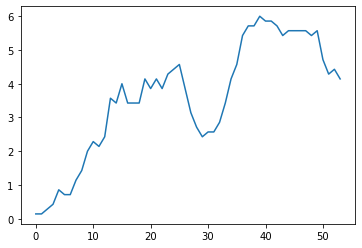

In [206]:
y = d_smooth
y = y[y > 0]
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [207]:
scale = c_smooth.max() / d_smooth.max()

In [208]:
%matplotlib inline

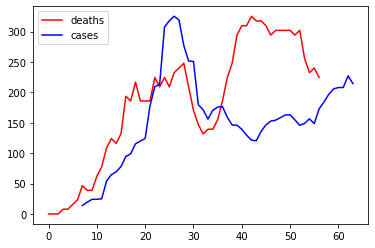

In [209]:
y = d_smooth * scale
x = np.arange(0, y.shape[0])
plt.plot(x, y, color='red', label='deaths')

y = c_smooth
x = np.arange(0, y.shape[0])
x += 7
plt.plot(x, y, color='blue', label='cases')

# plt.xlim(left=50)
plt.legend()
plt.show()

In [210]:
delays = np.arange(1, 25)
corr = []
for delay in delays:
    cases_past = []
    deaths_curr = []
    for i in range(delay, c_smooth.shape[0]):
        cases_past.append(c_smooth[i - delay])
        deaths_curr.append(d_smooth[i])
    co = np.corrcoef(cases_past, deaths_curr)[0, 1]
    corr.append(co)

In [216]:
delay = 5
colors = []
cases_past = []
deaths_curr = []
z = []
cc = np.diff(d_smooth, prepend = [0])
for i in range(delay + 1, c_smooth.shape[0]):
    cases_past.append(c_smooth[i - delay])
    deaths_curr.append(d_smooth[i])
    z.append(cc[i])
    colors.append(i)

In [217]:
np.corrcoef(cases_past, deaths_curr)[0, 1]

0.4518683373831602

In [218]:
%matplotlib inline

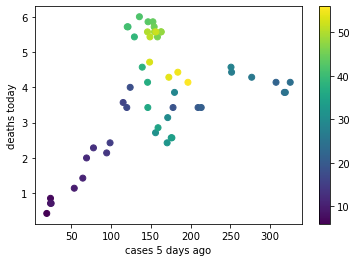

In [219]:
plt.scatter(cases_past, deaths_curr, c=colors)
plt.xlabel(f'cases {delay} days ago')
plt.ylabel('deaths today')
plt.colorbar()
plt.show()

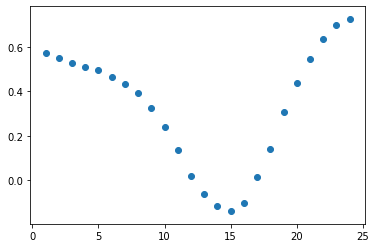

In [215]:
plt.scatter(delays, corr)

In [175]:
%matplotlib notebook

<IPython.core.display.Javascript object>


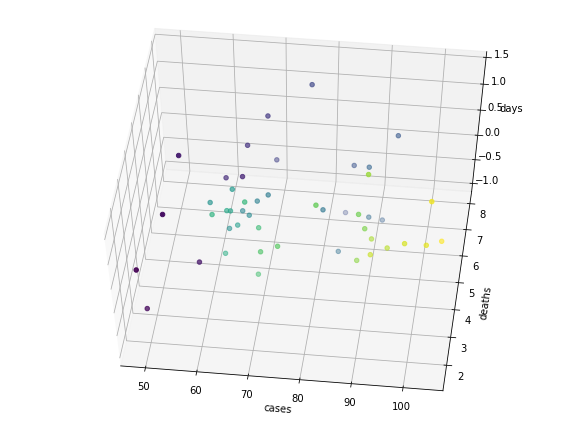

In [176]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cases_past, deaths_curr, z, c=colors)
ax.set_zlabel('days')
ax.set_xlabel('cases')
ax.set_ylabel('deaths')
# ax.set_zlim(40, 120)
plt.show()

In [718]:
(5 % 2)

1

In [90]:
def smooth_timeseries2(t, size=5):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(0, 0), (size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'),
        axis=1, arr=t)

In [117]:
cases_change = np.diff(cases)
deaths_change = np.diff(deaths)
s = 3
cases_change_s = smooth_timeseries2(cases_change, s)
deaths_change_s = smooth_timeseries2(deaths_change, s)

In [118]:
print(deaths_change_s.shape, cases_change_s.shape)

(3143, 114) (3143, 114)


In [137]:
delay = 14
cases_past = []
deaths_curr = []
colors = []
z = []
cc = np.diff(deaths_change_s, prepend = np.zeros((deaths_change_s.shape[0], 1)))

skip = 8
for county in range(cases_change_s.shape[0]):
    if deaths[county].max() < 50:
        continue
#     if 1850 < county < 1890:
#         continue
    for t in range(delay, cases_change_s.shape[1], skip):
        if t < 60:
            continue
        if deaths_change_s[county, t] == 0:
            continue
        cases_past.append(cases_change_s[county, t - delay])
        deaths_curr.append(deaths_change_s[county, t])
        pchange = (cc[county, t] - cc[county, t - delay]) / cc[county, t]
        pchange = np.nan_to_num(pchange, nan=0,posinf=0,neginf=0)
        z.append(county)
        colors.append(t)

<ipython-input-137-f934774977b9>:21: RuntimeWarning: invalid value encountered in double_scalars
  pchange = (cc[county, t] - cc[county, t - delay]) / cc[county, t]
<ipython-input-137-f934774977b9>:21: RuntimeWarning: divide by zero encountered in double_scalars
  pchange = (cc[county, t] - cc[county, t - delay]) / cc[county, t]


In [138]:
print(len(deaths_curr))

1171


In [139]:
np.corrcoef(cases_past, deaths_curr)[0, 1]

0.8554528583892755

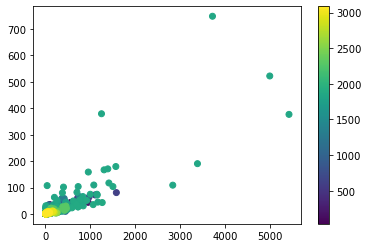

In [98]:
plt.scatter(cases_past, deaths_curr, c=colors)
plt.colorbar()
#plt.xlim(right=2000)
#plt.ylim(0, 350)

<IPython.core.display.Javascript object>


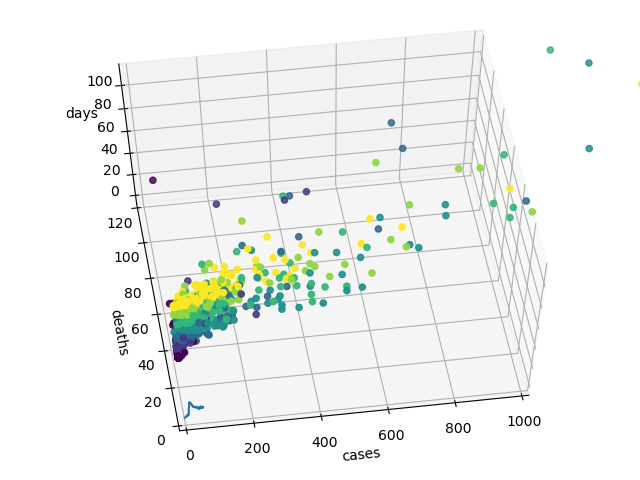

In [140]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cases_past, deaths_curr, colors, c=colors)
ax.set_zlabel('days')
ax.set_xlabel('cases')
ax.set_ylabel('deaths')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 120)
# ax.set_zlim(-4, 4)
plt.show()